# Bow Box, A hand controllable gesture based synthesizer
Created using Modal synthesis and tuned waveguides
https://www.music.mcgill.ca/~gary/618/week11/node12.html

In [1]:
import soundfile as sf
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal 
from aenum import Enum, skip
import time
import math
import os

# Friction Curves
source: https://www.engineeringtoolbox.com/friction-coefficients-d_778.html
https://engineeringlibrary.org/reference/coefficient-of-friction 

map touch sensor to circle aka sin() -1 to 1

$n$ = each node.

$V_{il}(n)$ and $V_{ir}(n)$ = incoming velocities at the excitation point arriveing from left to right

$V_{h}$ = $\sum_{n}$ $V_{il}(n)$ + $V_{ir}(n)$

In [2]:
class material(Enum):
    @skip
    class aluminum(Enum):
        static = 0.001
        dynamic = 0.999

# print(material.aluminum.static.value)


def frictionCurve(static: float, dynamic: float, initial_velocity: float, relative_velocity: float):
    if 0 == (initial_velocity + relative_velocity):
        return 0
    else:
        return dynamic + ((static - dynamic) * initial_velocity) / (initial_velocity + relative_velocity)



# print(test)
# print(math.floor(1.1))
speed_in_air = 343000 / 44100

print(speed_in_air)
last_val = 0.5
current = 0.75

test = frictionCurve(material.aluminum.static.value, material.aluminum.dynamic.value, speed_in_air * 100, speed_in_air)
print(1800 / 44100)
testArray = np.zeros(2)
testArray[0]
testArray[1]

7.777777777777778
0.04081632653061224


0.0

# First Order All Pass

In [3]:
class allpass_filter():
    def __init__(self, sampling_rate: float, frequency: float, bandwidth: float):
        # Define Coefs
        self.b0: float = 0
        self.b1: float = 0
        self.b3: float = 0
        self.a1: float = 0
        self.a2: float = 0
        self.K: float = 0
        self.Q: float = 0

        # Define Feedback Filters
        self.xh1: float = 0
        self.xh2: float = 0
        
        # Define Common Params
        self.frequency: float = frequency
        self.bandwidth: float = bandwidth
        self.samplerate:float = sampling_rate

        # Calculate Coefs
        self.__calculate_coefficients()
    
    def __calculate_coefficients(self):
        self.K = np.tan((2 * np.pi * self.frequency) / self.samplerate)
        self.K2 = self.K * self.K
        self.Q = self.frequency / self.bandwidth
        self.b0 = (self.K2 * self.Q - self.K + self.Q) / (self.K2 * self.Q + self.K + self.Q)
        self.b1 = (2 * self.Q * (self.K2 - 1)) / (self.K2 * self.Q + self.K + self.Q)
        self.b2 = 1
        self.a1 = self.b1
        self.a2 = self.b0
    
    def process(self, input: float):
        xh = input - self.a1 * self.xh1 - self.a2 * self.xh2
        output = self.b0 * xh + self.b1 * self.xh1 + self.b2 * self.xh2

        # Set Feedback
        self.xh2 = self.xh1
        self.xh1 = xh

        return output
        


# Bow Table
Ported from STK Bowtable.h
https://github.com/thestk/stk/blob/master/include/BowTable.h

In [4]:
class bowtable():
    def __init__(self, offset, slope, min_value, max_value):
        self.offset = offset
        self.slope = slope
        self.min_output = min_value
        self.max_output = max_value
    def process(self, input: float):
        sample = input + self.offset
        sample *= self.slope

        output = abs(sample + 0.75)
        output = output**-4

        if output < self.min_output:
            output = self.min_output
        if output > self.max_output:
            output = self.max_output

        return output



# Digital Wave Guide Filter
y(n) = 2Rcos(theta * y(n - 1)) - R^2y(n - 2) + x(n)
R = e^(-d/FS)
Theta = w / FS
w = 2pi f
FS = Sampling rate

In [5]:
# Fractional Delay Based off of Dafx Book Pg: 73-75
class fractional_delay:
    def __init__(self, M: float):
        # Get Delay length and 
        self.delay_length = M
        self.M = math.floor(M)
        self.frac = self.delay_length - self.M 

        # Read and Write Pointers
        self.read = 1
        self.write = 0

        # Init Delay line and set Delay Length to right Value
        self.delay = 0
        if self.delay_length > 2:
            self.delay = np.zeros(self.M)
            self.delay_length = self.M
        else:
            self.delay = np.zeros(2)
            self.delay_length = 2

        # Create pointer for Last Sample
        self.last_sample = self.delay_length - 1

    def process(self, input: float):
        # Get Output
        output = self.delay[self.last_sample] * self.frac + self.delay[self.read] * (1 - self.frac)
        self.delay[self.write] = input

        # Move Pointers
        self.read += 1
        self.write += 1
        self.last_sample += 1

        # Make sure pointers don't go out of bounds
        if self.write >= self.delay_length:
            self.write = 0
        if self.read >= self.delay_length:
            self.read = 0
        if self.last_sample >= self.delay_length:
            self.last_sample = 0

        return output

class wave_guide:
    def __init__(self, N: int):
        self.delay_line = np.zeros(N + 1)
        self.read: int = 1
        self.write: int = 0
        self.delay_length = N + 1

    def process(self, input: float):
        output = self.delay_line[self.read]
        self.delay_line[self.write] = input
        
        self.read += 1
        self.write += 1

        if self.write >= self.delay_length:
            self.write = 0
        if self.read >= self.delay_length:
            self.read = 0

        return output
    
    def get_output(self):
        return self.delay_line[-1]
    
    def get_delay_len(self):
        return len(self.delay_line)
    
    def get_read(self):
        return self.read
    
    def get_write(self):
        return self.write



class single_mode:
    # Arguments that don't need inits
    y1: float = 0
    y2: float = 0
    x1: float = 0
    x2: float = 0
    feedback: float = 0
    last_source: float = 0
    l1: float = 0
    l2: float = 0

    # Incoming Velocities Left and Right
    vil: float = 0
    vir: float = 0

    # Outgoing velocities Left and Right

    def __init__(self, samplingRate: float, frequency: float, dampening: float):
        # Init all these varibles on creation
        self.sampling_rate = samplingRate
        self.frequency = frequency
        self.dampening = dampening
        self.allpass = allpass_filter(self.sampling_rate, self.frequency, 2)

        # Get the constants for the bp filter
        Bandwidth = 2
        R = 1 - (Bandwidth / 2)
        omega = math.cos(self.frequency)
        w = 2 * np.pi * self.frequency
        theta = w / self.sampling_rate
        theta = ((2 * R) / (1 + R*R)) * omega

        self.b = 2 * R * theta
        self.a1 = (R * R)
        self.c3 = R


        # Get Freq of waveguides and init
        # Delay Length = Samplerate / Frequency
        # k1: int = round(self.c2 / (freq_one + (self.c1 * freq_one**2)/self.frequency))
        # k2: int = round(self.c2 / (freq_two + (self.c1 * freq_two**2)/self.frequency))
        # k1: float = self.sampling_rate / (self.frequency)
        k1: float =  self.sampling_rate / (self.frequency)
        # k1: float = (self.frequency + beats) / 1000
        # k2: float = (self.frequency - beats) / 1000
        self.wave_guides = fractional_delay(k1)
        print("K1: ", k1)

    # There are faster ways but this works for now
    def __process_bandpass( self, input: float):
        # Process BP filter
        output = self.b  * self.y1 - self.a1 * self.y2 - self.c3 * self.x2 + input
        self.x2 = self.x1
        self.x1 = input
        self.y2 = self.y1
        self.y1 = output
        return output
        
    def process(self, input: float, feedback_input):
        coupling_constant = 0.98
        self.last_source = 0
        speed_in_air = 343000 / self.sampling_rate
        
        
        # Create a simple matrix for the outputs
        output_matrix: float = 0
        bandpass_out: float = 0
        source: float = 0
        
        # Set Input
        source = input + self.feedback

        #allpass_out = self.allpass.process(source)

        # Get bandpass Outs
        bandpass_out = self.__process_bandpass(source)

        # Get Output
        output_matrix = self.wave_guides.process(bandpass_out)

        coupling_constant = frictionCurve(material.aluminum.static.value, material.aluminum.dynamic.value, abs(input * speed_in_air), abs(((input + output_matrix) * speed_in_air) ))

        # Set Feedback
        self.feedback = output_matrix * coupling_constant


        # Second half of waveguides
        #output_matrix[0,1] = self.l1 = self.wave_guides[0,1].process(bandpass_out)
        # # Bottom Right  
        # self.vir = output_matrix[1,1] = self.wave_guides[1,1].process(output_matrix[0,0])
        # # Bottom Left
        # self.vil = output_matrix[1,0] = self.wave_guides[1,0].process(output_matrix[0,1])
        
        # self.vil = output_matrix[0,1]
        # self.vir = output_matrix[1,1]
        # self.vol = output_matrix[1,0]
        # self.vor = output_matrix[0,0]

        #return [bandpass_out, output_matrix[0,1], output_matrix[1,1]]
        #return bandpass_out
        #mixed_out = output_matrix + output_matrix
        return output_matrix
    
test = single_mode(44100, 440, 38)



K1:  100.22727272727273


In [6]:
# Modals
class vio_modes:
    def __init__(self, samplingRate: float, frequency: float, dampening: float):
        self.left_harmonics = np.array([single_mode(samplingRate, frequency - 0.45, dampening),
                              single_mode(samplingRate, frequency - 0.45, dampening),
                              single_mode(samplingRate, (frequency - 0.45), dampening),
                              single_mode(samplingRate, (frequency - 0.45), dampening),
                              ])
        self.right_harmonics = np.array([single_mode(samplingRate, frequency + 0.45, dampening),
                        single_mode(samplingRate, frequency + 0.45, dampening),
                        single_mode(samplingRate, (frequency + 0.45), dampening),
                        single_mode(samplingRate, (frequency + 0.45), dampening),
                        ])
        self.amp_values = np.array([0.9, 0.7, 1, 0.8])
    def process(self, input: float, debug= False):
        output: float = 0
        right_out: float = 0
        left_out: float = 0
        
        right_out = self.right_harmonics[0].process(input, 0)  * 1
        left_out = self.left_harmonics[0].process(input, 0) * -1

        # for i in range(1, len(self.right_harmonics)):
        #     right_out += self.right_harmonics[i].process(right_out, 0) * -1
        #     left_out += self.left_harmonics[i].process(left_out, 0) * -1

        # right_out *= 0.25
        # left_out *= 0.25
        # Soundes worse with more harmonics
        # right_out = self.right_harmonics[0].process(input, 0)  * -1
        # right_out += self.right_harmonics[1].process(right_out, 0)  * -1

        # left_out = self.left_harmonics[0].process(input, 0) * -1
        # left_out += self.left_harmonics[1].process(left_out, 0) * -1

        output = (right_out + left_out )
        # for i in range(0, len(self.left_harmonics)):
        #     self.left_out += self.left_harmonics[i].process(output) * 0.09


        return output

# Test Runner Function

In [7]:
def internalTestRunner(outputFileName: str, fileSec: int, sampleRate: int, speed: int):
    print()
    print("### {} ###".format(outputFileName))
    sampleTime: any = sampleRate / speed
    impulse = np.zeros(sampleRate)

    valArray = np.rint(np.array([0, sampleTime, sampleTime * 2, sampleTime * 3]))
    numVal = 1
    impulse[0] = numVal
    # impulse[11025] = numVal
    # impulse[11025 * 2] = numVal
    # impulse[11025 * 3] = numVal
    
    # for i in range(0, speed):
    #     currentVal = np.rint(i * sampleTime)
    #     impulse[valArray[i]] = 1

    sine_wave: float = [1 - np.cos(2 * np.pi * x/(sampleRate)) for x in range(sampleRate)]
    fullImpulse = np.tile(impulse, fileSec)
    

    newFilter = vio_modes(sampleRate, Aura.Kidney.value, 38)
    #newFilter = single_mode(sampleRate, Aura.Kidney.value, 38, 1)
    outputSignal = np.zeros(len(fullImpulse))
    debug = True
    for i in range(0, len(fullImpulse)):
        if i != 0:
            debug = False            
        outputSignal[i] = newFilter.process(fullImpulse[i])

    
    outputLocation = "exports/" + outputFileName +  ".wav"
    sf.write(outputLocation, outputSignal, sampleRate)


### test1 ###
--- Opened File 0.0030803680419921875 seconds ---
--- File Info 0.008813142776489258 seconds ---
--- Filter 0.022505998611450195 seconds ---


--- Sine Wave 1.2178010940551758 seconds ---
K1:  402.555910543131
K1:  402.555910543131
K1:  402.555910543131
K1:  402.555910543131
K1:  399.27569035762787
K1:  399.27569035762787
K1:  399.27569035762787
K1:  399.27569035762787
--- Init 1.2183170318603516 seconds ---
--- Process 5.745557069778442 seconds ---
--- Write File 5.752477169036865 seconds ---
Input:  3.1604938271604937 Output:  0.0
Input:  3.1604934849950146 Output:  3.1604938271604937
Input:  3.1604924584989686 Output:  3.1604934849950146
Input:  3.1604907476735207 Output:  3.1604924584989686
Input:  3.160488352520616 Output:  3.1604907476735207
Input:  3.160485273042978 Output:  3.160488352520616
Input:  3.160481509244106 Output:  3.160485273042978
Input:  3.1604770611282795 Output:  3.160481509244106
Input:  3.160471928700556 Output:  3.1604770611282795
Input:  3.160466111966766 Output:  3.160471928700556
Input:  3.160459610933526 Output:  3.160466111966766


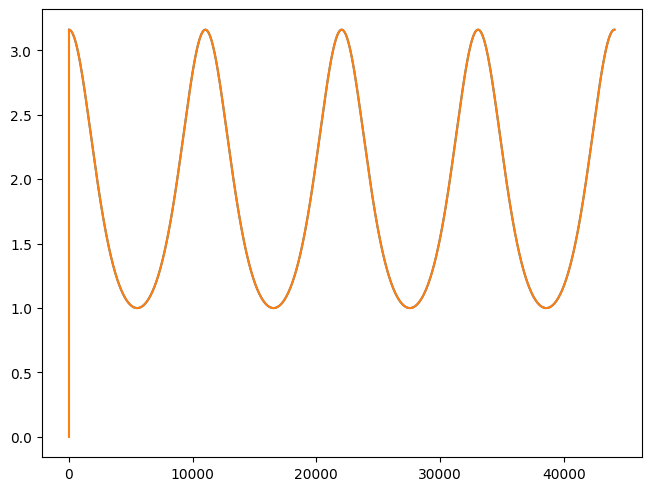

In [8]:

bow_offset: float = 0
bow_slope: float = 0.125
bow_min: float = 0
bow_max: float = 4

def testRunner(inputFile, outputFileName):
    print()
    print("### {} ###".format(outputFileName))
    start_time = time.time()    
    inputLocation = "imports/" + inputFile
    with sf.SoundFile(inputLocation) as input_file:
        print("--- Opened File %s seconds ---" % (time.time() - start_time))
        y =  np.asarray(input_file.read()) # Read input File
        Fs = input_file.samplerate # Get sample rate
        int_sample = int(Fs)
        fileLength = len(y) # Get length of input file
        fileSec = fileLength / Fs # Get length of input file in seconds
        impulse = np.zeros(fileLength)
        outputSignal = np.zeros(fileLength)
        #impulse[1] = 1
        freq = 440

        print("--- File Info %s seconds ---" % (time.time() - start_time))

        sos = signal.butter(2, freq, 'low', fs=Fs, output='sos')
        filtered = signal.sosfilt(sos, y)
        print("--- Filter %s seconds ---" % (time.time() - start_time))
        # sos2 = signal.butter(2, freq, 'high', fs=Fs, output='sos')
        # filtered2 = signal.sosfilt(sos2, filtered)

        bow_table = bowtable(bow_offset, bow_slope, bow_min, bow_max)
        sine_wave: float = [bow_table.process(1 - (np.cos(2 * np.pi * x * 0.25 / int(Fs)))) / 6 for x in range(int(Fs * fileSec))]
        #y = np.add(0, filtered)
        print("--- Sine Wave %s seconds ---" % (time.time() - start_time))
        newFilter = vio_modes(Fs, 110, 38)
        print("--- Init %s seconds ---" % (time.time() - start_time))
        for i in range(0, len(y)):
            outputSignal[i] = newFilter.process(filtered[i] * sine_wave[i])
        
        sos2 = signal.butter(1, freq * 2, 'low', fs=Fs, output='sos')
        filteredFinal = signal.sosfilt(sos2, outputSignal)
        print("--- Process %s seconds ---" % (time.time() - start_time))

        #outputSignal = [] # Output signal
        # for i in range(0, len(y)):
        #     outputSignal.append((newout[i]))

        outputLocation = "exports/" + outputFileName +  ".wav"
        sf.write(outputLocation, outputSignal, Fs)
        print("--- Write File %s seconds ---" % (time.time() - start_time))
    return "Successfully Wrote to File"



def delay_test(outputFileName: str, fileSec: int, sampleRate: int):
    delay_length = round(sampleRate * (fileSec / 2))
    delay_time = 0.75
    delay_line = fractional_delay(delay_time)
    #print("Ideal Length: ", delay_length, "Real Length: ", delay_line.get_delay_len())
    impulse = np.zeros(sampleRate * fileSec)
    outputSignal = np.zeros(sampleRate)
    impulse[0] = 1

    bow = bowtable(bow_offset, bow_slope, bow_min, bow_max)
    sine_wave: float = [bow.process(1 - np.cos(2 * np.pi * 4 * x/(sampleRate))) for x in range(sampleRate)]

    # for i in range(0, len(sine_wave)):
    #     impulse[i] = sine_wave[i]

    for i in range(0, len(sine_wave)):
        outputSignal[i] = delay_line.process(sine_wave[i])
        if i < delay_time + 10:
            print("Input: ", sine_wave[i], "Output: ", outputSignal[i])
        #print(i, "Input: ", impulse[i], "Output: ", outputSignal[i], "read: ", delay_line.get_read())

    # outputLocation = "exports/" + outputFileName +  ".wav"
    # sf.write(outputLocation, outputSignal, sampleRate)

    fig, ax1 = plt.subplots(1, 1, layout='constrained')
    ax1.plot(sine_wave)
    ax1.plot(outputSignal)

testRunner("whitenoise.wav", "test1")
internalTestRunner("test2", 5, 44100, 4)
# testRunner("whitenoise_strike.wav", "test3")
delay_test("delay_test", 1, 44100)
